# Global Sensitivity Analysis

In [2]:
# import all necessary python libraries and the pyNetLogo library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')
import pyNetLogo

# import sensisitivity analysis' python packages
from SALib.sample import latin
from SALib.analyze import sobol
from SALib.sample import saltelli

## Sensitivity Analysis on Levers

In [3]:
# set up the model
netlogo = pyNetLogo.NetLogoLink(gui=False) #Mac users should set this to False
netlogo.load_model('Model.nlogo')

In [2]:
problem = {
  'num_vars': 8,
  'names': ['random-seed',
           'administrative-network-meetings',
           'total-project-proposal-frequency',
           'informal-meetings-frequency',
           'green-energy-openness-change',
           'political-variety-change',
           'max-project-capacity',
           'random-intial-trust'],
  'bounds': [[0, 100],
            [0, 25],
            [0, 25],
            [0, 25],
            [-5,5],
            [-5,5],
            [0, 25],
            [0, 1]]
}

n = 50
# Generates an input array of shape (n*(2p+2), p) with rows for each 
# experiment and columns for each input, using the saltelli sampler for global sensitivity analysis
param_values = saltelli.sample(problem, n, calc_second_order=True)

df = pd.DataFrame(param_values)
df.iloc[:,-1] = df.iloc[:,-1].astype("bool")
param_values = np.array(df)
param_values.shape

(900, 8)

In [4]:
results = pd.DataFrame(columns=['MW_implemented_wind', 'MW_implemented_solar', 'MW_implemented_urban'])

for run in range(param_values.shape[0]):
    # Set the input parameters
    for i, name in enumerate(problem['names']):
        if name == 'random-seed':
            # The NetLogo random seed requires a different syntax
            netlogo.command('random-seed {}'.format(param_values[run,i]))
        else:
            # Otherwise, assume the input parameters are global variables
            netlogo.command('set {0} {1}'.format(name, param_values[run,i]))

    netlogo.command('setup')
    # Run for 100 ticks and return the number of sheep and wolf agents at 
    # each time step
    MW_implemented = netlogo.repeat_report(['current-wind-production','current-solar-production', 'current-urban-production'], 360)

    # For each run, save the value of MW_implemented
    results.loc[run, 'MW_implemented_wind'] = MW_implemented['current-wind-production'].max()
    results.loc[run, 'MW_implemented_solar'] = MW_implemented['current-solar-production'].max()
    results.loc[run, 'MW_implemented_urban'] = MW_implemented['current-urban-production'].max()

In [27]:
results

,MW_implemented_wind,MW_implemented_solar,MW_implemented_urban,MW_Total


In [8]:
results.sum(axis=1)

0       586.5
1       522.5
2       586.5
3        43.5
4       630.5
        ...  
895    2741.0
896    2132.5
897    2223.0
898    1949.5
899    1949.5
Length: 900, dtype: float64

In [26]:
results_aggregated = results
results_aggregated["MW_Total"] = results_aggregated.sum(axis=1)
results_aggregated

,MW_implemented_wind,MW_implemented_solar,MW_implemented_urban,MW_Total


In [10]:
Si = sobol.analyze(problem, results_aggregated['MW_Total'].values, calc_second_order=True)

In [11]:
Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])
Si_df

,ST,ST_conf,S1,S1_conf
random-seed,0.013382,0.007693,-0.017357,0.034217
administrative-network-meetings,0.383317,0.175413,0.385405,0.298434
total-project-proposal-frequency,0.704920,0.265680,0.599801,0.264738
informal-meetings-frequency,0.007119,0.004101,0.009548,0.031460
green-energy-openness-change,0.079346,0.046201,0.053550,0.071143
political-variety-change,0.003594,0.001994,-0.008587,0.021107
max-project-capacity,0.061146,0.068825,0.031492,0.035864
random-intial-trust,0.000000,0.000000,0.000000,0.000000


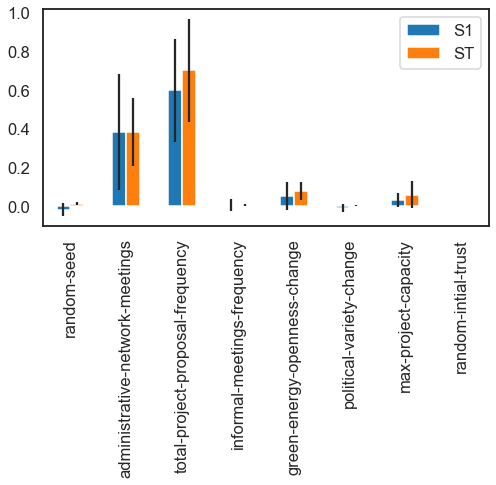

<Figure size 432x288 with 0 Axes>

In [23]:
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,4)

plt.show()
plt.savefig("./Graphs/Global_sensitivity_analysis_on_levers")

In [25]:
%matplotlib inline
import itertools
from math import pi


def normalize(x, xmin, xmax):
    return (x-xmin)/(xmax-xmin)


def plot_circles(ax, locs, names, max_s, stats, smax, smin, fc, ec, lw,
                 zorder):
    s = np.asarray([stats[name] for name in names])
    s = 0.01 + max_s * np.sqrt(normalize(s, smin, smax))

    fill = True
    for loc, name, si in zip(locs, names, s):
        if fc=='w':
            fill=False
        else:
            ec='none'

        x = np.cos(loc)
        y = np.sin(loc)

        circle = plt.Circle((x,y), radius=si, ec=ec, fc=fc, transform=ax.transData._b,
                            zorder=zorder, lw=lw, fill=True)
        ax.add_artist(circle)


def filter(sobol_indices, names, locs, criterion, threshold):
    if criterion in ['ST', 'S1', 'S2']:
        data = sobol_indices[criterion]
        data = np.abs(data)
        data = data.flatten() # flatten in case of S2
        # TODO:: remove nans

        filtered = ([(name, locs[i]) for i, name in enumerate(names) if
                     data[i]>threshold])
        filtered_names, filtered_locs = zip(*filtered)
    elif criterion in ['ST_conf', 'S1_conf', 'S2_conf']:
        raise NotImplementedError
    else:
        raise ValueError('unknown value for criterion')

    return filtered_names, filtered_locs


def plot_sobol_indices(sobol_indices, criterion='ST', threshold=0.01):
    '''plot sobol indices on a radial plot

    Parameters
    ----------
    sobol_indices : dict
                    the return from SAlib
    criterion : {'ST', 'S1', 'S2', 'ST_conf', 'S1_conf', 'S2_conf'}, optional
    threshold : float
                only visualize variables with criterion larger than cutoff

    '''
    max_linewidth_s2 = 15#25*1.8
    max_s_radius = 0.3

    # prepare data
    # use the absolute values of all the indices
    #sobol_indices = {key:np.abs(stats) for key, stats in sobol_indices.items()}

    # dataframe with ST and S1
    sobol_stats = {key:sobol_indices[key] for key in ['ST', 'S1']}
    sobol_stats = pd.DataFrame(sobol_stats, index=problem['names'])

    smax = sobol_stats.max().max()
    smin = sobol_stats.min().min()

    # dataframe with s2
    s2 = pd.DataFrame(sobol_indices['S2'], index=problem['names'],
                      columns=problem['names'])
    s2[s2<0.0]=0. #Set negative values to 0 (artifact from small sample sizes)
    s2max = s2.max().max()
    s2min = s2.min().min()

    names = problem['names']
    n = len(names)
    ticklocs = np.linspace(0, 2*pi, n+1)
    locs = ticklocs[0:-1]

    filtered_names, filtered_locs = filter(sobol_indices, names, locs,
                                           criterion, threshold)

    # setup figure
    fig = plt.figure()
    ax = fig.add_subplot(111, polar=True)
    ax.grid(False)
    ax.spines['polar'].set_visible(False)
    ax.set_xticks(ticklocs)

    ax.set_xticklabels(names)
    ax.set_yticklabels([])
    ax.set_ylim(top=1.4)
    legend(ax)

    # plot ST
    plot_circles(ax, filtered_locs, filtered_names, max_s_radius,
                 sobol_stats['ST'], smax, smin, 'w', 'k', 1, 9)

    # plot S1
    plot_circles(ax, filtered_locs, filtered_names, max_s_radius,
                 sobol_stats['S1'], smax, smin, 'k', 'k', 1, 10)

    # plot S2
    for name1, name2 in itertools.combinations(zip(filtered_names, filtered_locs), 2):
        name1, loc1 = name1
        name2, loc2 = name2

        weight = s2.loc[name1, name2]
        lw = 0.5+max_linewidth_s2*normalize(weight, s2min, s2max)
        ax.plot([loc1, loc2], [1,1], c='darkgray', lw=lw, zorder=1)

    return fig


from matplotlib.legend_handler import HandlerPatch
class HandlerCircle(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        p = plt.Circle(xy=center, radius=orig_handle.radius)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

def legend(ax):
    some_identifiers = [plt.Circle((0,0), radius=5, color='k', fill=False, lw=1),
                        plt.Circle((0,0), radius=5, color='k', fill=True),
                        plt.Line2D([0,0.5], [0,0.5], lw=8, color='darkgray')]
    ax.legend(some_identifiers, ['ST', 'S1', 'S2'],
              loc=(1,0.75), borderaxespad=0.1, mode='expand',
              handler_map={plt.Circle: HandlerCircle()})


sns.set_style('whitegrid')
fig = plot_sobol_indices(Si, criterion='ST', threshold=0.005)
fig.set_size_inches(7,7)
plt.show()
# plt.savefig("./Graphs/Global_sensitivity_analysis_on_levers_ballpark")

ValueError: Shape of passed values is (8, 2), indices imply (7, 2)

## Sensitivity Analysis on uncertain parameters

In [10]:
# set up the model
netlogo = pyNetLogo.NetLogoLink(gui=False) #Mac users should set this to False
netlogo.load_model('Model.nlogo')

In [17]:
problem = {
  'num_vars': 7,
  'names': ['random-seed',
            'trust-increase-in-formal-meetings',
           'green-energy-openness-increase-in-formal-meetings',
           'trust-increase-in-informal-meetings',
           'experience-scaling-factor',
           'n-of-most-trusted-colleagues',
           'percentage-delayed'],
  'bounds': [[0, 100],
            [1.0001, 1.001],
            [1.0005, 1.005],
            [1.001, 1.02],
            [10,50],
            [2,5],
            [0.3, 0.8]]
}

n = 500
# Generates an input array of shape (n*(2p+2), p) with rows for each 
# experiment and columns for each input, using the saltelli sampler for global sensitivity analysis
param_values = saltelli.sample(problem, n, calc_second_order=True)
param_values.shape

(8000, 7)

In [18]:
results = pd.DataFrame(columns=['MW_implemented_wind', 'MW_implemented_solar', 'MW_implemented_urban'])

for run in range(param_values.shape[0]):
    netlogo.command('setup')
    
    # Set the input parameters 
    for i, name in enumerate(problem['names']):
        if name == 'random-seed':
            # The NetLogo random seed requires a different syntax
            netlogo.command('random-seed {}'.format(param_values[run,i]))
        else:
            # Otherwise, assume the input parameters are global variables
            netlogo.command('set {0} {1}'.format(name, param_values[run,i]))

    
    # Run for 100 ticks and return the number of sheep and wolf agents at 
    # each time step
    MW_implemented = netlogo.repeat_report(['current-wind-production','current-solar-production', 'current-urban-production'], 360)

    # For each run, save the value of MW_implemented
    results.loc[run, 'MW_implemented_wind'] = MW_implemented['current-wind-production'].max()
    results.loc[run, 'MW_implemented_solar'] = MW_implemented['current-solar-production'].max()
    results.loc[run, 'MW_implemented_urban'] = MW_implemented['current-urban-production'].max()

In [19]:
results.sum(axis=1)
results_aggregated = results
results_aggregated["MW_Total"] = results_aggregated.sum(axis=1)
results_aggregated

,MW_implemented_wind,MW_implemented_solar,MW_implemented_urban,MW_Total
0,499,1772,477,2748.0
1,477,1607,456,2540.0
2,687,2040,423,3150.0
3,178,532,333,1043.0
4,494,2067,417,2978.0
...,...,...,...,...
7995,223,1197,313.5,1733.5
7996,215,1023,327,1565.0
7997,292,1080,295.5,1667.5
7998,180,1012,310.5,1502.5


In [20]:
Si = sobol.analyze(problem, results_aggregated['MW_Total'].values, calc_second_order=True)
Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])
Si_df

,ST,ST_conf,S1,S1_conf
random-seed,0.067953,0.008954,-0.007766,0.035002
trust-increase-in-formal-meetings,0.061071,0.008544,-0.001351,0.030078
green-energy-openness-increase-in-formal-meetings,0.981400,0.095058,0.893368,0.103302
trust-increase-in-informal-meetings,0.043888,0.006366,-0.002235,0.024970
experience-scaling-factor,0.062599,0.010697,-0.015241,0.031323
n-of-most-trusted-colleagues,0.052188,0.009373,-0.019200,0.028573
percentage-delayed,0.078106,0.011869,-0.009155,0.037537


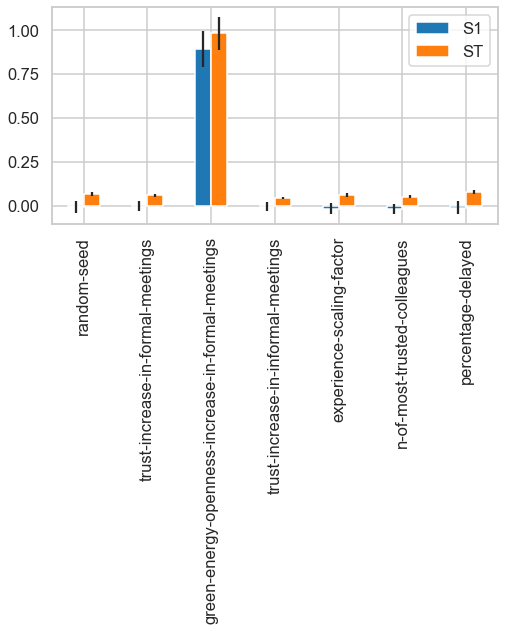

<Figure size 432x288 with 0 Axes>

In [21]:
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,4)

plt.show()
plt.savefig("./Graphs/Global_sensitivity_analysis_on_uncertainties")

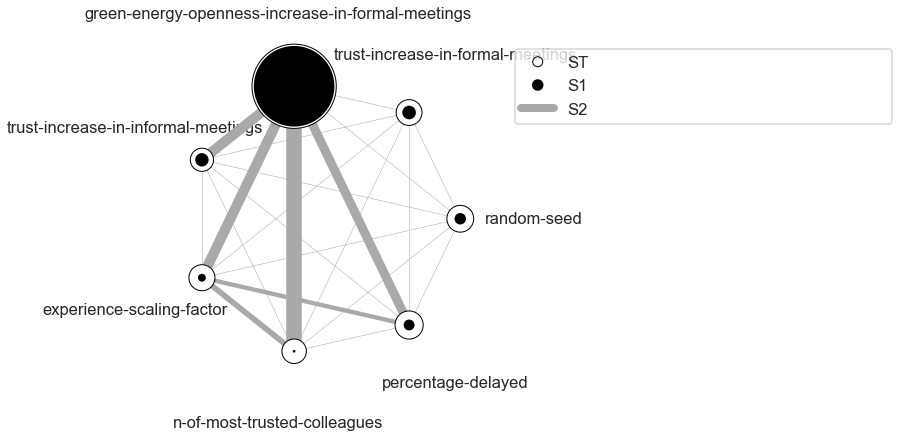

<Figure size 432x288 with 0 Axes>

In [22]:
%matplotlib inline
import itertools
from math import pi


def normalize(x, xmin, xmax):
    return (x-xmin)/(xmax-xmin)


def plot_circles(ax, locs, names, max_s, stats, smax, smin, fc, ec, lw,
                 zorder):
    s = np.asarray([stats[name] for name in names])
    s = 0.01 + max_s * np.sqrt(normalize(s, smin, smax))

    fill = True
    for loc, name, si in zip(locs, names, s):
        if fc=='w':
            fill=False
        else:
            ec='none'

        x = np.cos(loc)
        y = np.sin(loc)

        circle = plt.Circle((x,y), radius=si, ec=ec, fc=fc, transform=ax.transData._b,
                            zorder=zorder, lw=lw, fill=True)
        ax.add_artist(circle)


def filter(sobol_indices, names, locs, criterion, threshold):
    if criterion in ['ST', 'S1', 'S2']:
        data = sobol_indices[criterion]
        data = np.abs(data)
        data = data.flatten() # flatten in case of S2
        # TODO:: remove nans

        filtered = ([(name, locs[i]) for i, name in enumerate(names) if
                     data[i]>threshold])
        filtered_names, filtered_locs = zip(*filtered)
    elif criterion in ['ST_conf', 'S1_conf', 'S2_conf']:
        raise NotImplementedError
    else:
        raise ValueError('unknown value for criterion')

    return filtered_names, filtered_locs


def plot_sobol_indices(sobol_indices, criterion='ST', threshold=0.01):
    '''plot sobol indices on a radial plot

    Parameters
    ----------
    sobol_indices : dict
                    the return from SAlib
    criterion : {'ST', 'S1', 'S2', 'ST_conf', 'S1_conf', 'S2_conf'}, optional
    threshold : float
                only visualize variables with criterion larger than cutoff

    '''
    max_linewidth_s2 = 15#25*1.8
    max_s_radius = 0.3

    # prepare data
    # use the absolute values of all the indices
    #sobol_indices = {key:np.abs(stats) for key, stats in sobol_indices.items()}

    # dataframe with ST and S1
    sobol_stats = {key:sobol_indices[key] for key in ['ST', 'S1']}
    sobol_stats = pd.DataFrame(sobol_stats, index=problem['names'])

    smax = sobol_stats.max().max()
    smin = sobol_stats.min().min()

    # dataframe with s2
    s2 = pd.DataFrame(sobol_indices['S2'], index=problem['names'],
                      columns=problem['names'])
    s2[s2<0.0]=0. #Set negative values to 0 (artifact from small sample sizes)
    s2max = s2.max().max()
    s2min = s2.min().min()

    names = problem['names']
    n = len(names)
    ticklocs = np.linspace(0, 2*pi, n+1)
    locs = ticklocs[0:-1]

    filtered_names, filtered_locs = filter(sobol_indices, names, locs,
                                           criterion, threshold)

    # setup figure
    fig = plt.figure()
    ax = fig.add_subplot(111, polar=True)
    ax.grid(False)
    ax.spines['polar'].set_visible(False)
    ax.set_xticks(ticklocs)

    ax.set_xticklabels(names)
    ax.set_yticklabels([])
    ax.set_ylim(top=1.4)
    legend(ax)

    # plot ST
    plot_circles(ax, filtered_locs, filtered_names, max_s_radius,
                 sobol_stats['ST'], smax, smin, 'w', 'k', 1, 9)

    # plot S1
    plot_circles(ax, filtered_locs, filtered_names, max_s_radius,
                 sobol_stats['S1'], smax, smin, 'k', 'k', 1, 10)

    # plot S2
    for name1, name2 in itertools.combinations(zip(filtered_names, filtered_locs), 2):
        name1, loc1 = name1
        name2, loc2 = name2

        weight = s2.loc[name1, name2]
        lw = 0.5+max_linewidth_s2*normalize(weight, s2min, s2max)
        ax.plot([loc1, loc2], [1,1], c='darkgray', lw=lw, zorder=1)

    return fig


from matplotlib.legend_handler import HandlerPatch
class HandlerCircle(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        p = plt.Circle(xy=center, radius=orig_handle.radius)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

def legend(ax):
    some_identifiers = [plt.Circle((0,0), radius=5, color='k', fill=False, lw=1),
                        plt.Circle((0,0), radius=5, color='k', fill=True),
                        plt.Line2D([0,0.5], [0,0.5], lw=8, color='darkgray')]
    ax.legend(some_identifiers, ['ST', 'S1', 'S2'],
              loc=(1,0.75), borderaxespad=0.1, mode='expand',
              handler_map={plt.Circle: HandlerCircle()})


sns.set_style('whitegrid')
fig = plot_sobol_indices(Si, criterion='ST', threshold=0.005)
fig.set_size_inches(7,7)
plt.show()
plt.savefig("./Graphs/Global_sensitivity_analysis_on_uncertainties_ballpark")